In [69]:
#!/usr/bin/env python3

import datetime
import hashlib
import logging
import os
import re
import sys
import glob

import time
from time import sleep
from random import uniform

import pandas as pd
from dateutil import parser as dt_parser

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from deep_translator import GoogleTranslator
from googletrans import Translator

import re

import json

In [119]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = ('https://www.googleapis.com/auth/drive.readonly',)
MSG_DELETED = "This message was deleted"
MEDIA_OMITTED = "<Media omitted>"
SKIP_MSGS = (MSG_DELETED, MEDIA_OMITTED)
ACTION_LINE = re.compile(r"(?P<day>[0-9]+/[0-9]+/[0-9]+), (?P<tm>[0-9]+:[0-9]+ )- (?P<tail>[^:]+)$", re.IGNORECASE)
#ACTION_LINE = re.compile(r"You joined using this")
MSG_LINE = re.compile(r"(?P<day>[0-9]+/[0-9]+/[0-9]+), (?P<tm>[0-9]+:[0-9]+ )- (?P<sn>[^:]+): (?P<tail>.*?)$", re.IGNORECASE)
FILE_ATTACHED_RE = re.compile(r"(?P<fn>.*?) \(file attached\)")
GDRIVE_RE = re.compile(r"(?:https://|)drive\.google\.com/.*?/folders/(?P<drive_id>[a-zA-Z0-9_-]+)")
AWS_BUCKET_RE = re.compile(r"^[a-zA-Z0-9.\-_]{1,255}$")
DAY_FMT = "%d/%m/%Y"
MINUTES = datetime.timedelta(seconds=60)
GOOGLE_DRIVE = "GOOGLE_DRIVE"
REQ_WHATSAPP_ENV_VARS = (
    'WHATSAPP_DB_USERNAME',
    'WHATSAPP_DB_PASSWORD',
    'WHATSAPP_DB_NAME',
    'WHATSAPP_ALL_FILES_DB_COLLECTION',
    'WHATSAPP_MERGED_MSGS_DB_COLLECTION')
REQ_AWS_ENV_VARS = (
    'AWS_ACCESS_KEY_ID',
    'AWS_SECRET_ACCESS_KEY',
    'AWS_BUCKET')

# Silence unneccesary google api warnings
# https://github.com/googleapis/google-api-python-client/issues/299
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)


class Msg():
    __slots__ = [
        'dt',
        'sender_id',
        'source_type',
        'source_loc',
        'group_id',
        'content',
        'order',
        'file_idx',
        'file_datetime',
        'has_media',
        'media_file',
        'media_upload_loc',
        'media_mime_type',
    ]

    def __init__(self, **kwargs):
        self.dt = kwargs.pop('dt', None)
        if not self.dt and 'datetime' in kwargs:
            self.dt = datetime.datetime.fromisoformat(kwargs.pop('datetime'))
        self.has_media = kwargs.pop('has_media', False)
        self.sender_id = kwargs.pop('sender_id', "")
        self.group_id = kwargs.pop('group_id', "")
        self.source_type = kwargs.pop('source_type', GOOGLE_DRIVE)
        self.source_loc = kwargs.pop('source_loc', "")
        self.content = kwargs.pop('content', "")
        self.order = kwargs.pop('order', None)
        self.file_idx = kwargs.pop('file_idx', None)
        self.file_datetime = kwargs.pop('file_datetime', None)
        self.media_file = kwargs.pop('media_file', {})
        self.media_upload_loc = kwargs.pop('media_upload_loc', None)
        self.media_mime_type = kwargs.pop('media_mime_type', None)

        # for mongo
        kwargs.pop("_id", "")
        assert not kwargs

    def __repr__(self):
        return "<Msg %s: %s %s: %s>" % (self.order, self.dt, self.sender_id[:5],
                                        self.content[:50].replace('\n', '\\n'))

    def __eq__(self, other):
        return (abs((self.dt - other.dt).total_seconds()) <= 120
                and self.sender_id == other.sender_id
                and self.group_id == other.group_id
                and self.content == other.content)

    @staticmethod
    def create(match: re.Match, group_id: str, file_idx: int, source_loc: str):
        day_raw = match['day']
        #print("day_raw",day_raw)
        day = datetime.datetime.strptime(day_raw, DAY_FMT).date()
        tm_raw = match['tm']
        tm = dt_parser.parse(tm_raw).time()
        return Msg(
            dt=datetime.datetime.combine(day, tm),
            sender_id=encrypt_string(match['sn'].strip(), group_id),
            group_id=group_id,
            source_loc=source_loc,
            content=match['tail'],
            file_idx=file_idx,
        )

    def as_dict(self):
        return {
            'datetime': self.dt.isoformat(),
            'source_type': self.source_type,
            'source_loc': self.source_loc,
            'sender_id': self.sender_id,
            'group_id': self.group_id,
            'content': self.content,
            'order': self.order,
            'has_media': self.has_media,
            'media_upload_loc': self.media_upload_loc,
            'media_mime_type': self.media_mime_type,
        }

    @staticmethod
    def from_dict(d):
        return Msg(**d)

    def is_original(self):
        return self.content not in SKIP_MSGS

    def add_content_line(self, content_line: str):
        self.content += '\n' + content_line

    def set_order(self, order: int):
        self.order = order

    def set_file_datetime(self, file_datetime: datetime.datetime):
        self.file_datetime = file_datetime

    def make_media_msg(self, media_file: dict):
        self.has_media = True
        self.media_file = media_file or {}


def encrypt_string(string: str, salt2="") -> str:
    """
    Returns an encrypted string for anonymization of groups and phones
    """
    salt = os.environ['SCRAPER_SALT']
    return hashlib.pbkdf2_hmac('sha256', string.encode(),
                               salt.encode(), 1).hex()


def process_text_file(filename: str):
    """
    Given a whatsapp message thread text file, break that file into individual
    messages which are suitable for upload to mongo.
    """

    # 1. Build up the messages line-by-line
    group_id = encrypt_string(filename)
    print(group_id)
    msgs = []
    with open(filename) as f:
        content_lines = f.read().split('\n')
        #print(content_lines)
    current_msg = None
    for content_line in content_lines:
        #print(content_line)
        if ACTION_LINE.match(content_line):
            # action header is a subset of message header but if we get it,
            # it means the message is over and we should save the message
            #print("action line found")
            if current_msg:
                msgs.append(current_msg)
                current_msg = None
        if msg_match := MSG_LINE.match(content_line):
            if current_msg:
                msgs.append(current_msg)
            #print("message line found")
            current_msg = Msg.create(msg_match, group_id, 0, filename)
            continue
        if current_msg:
            #print("current message")
            current_msg.add_content_line(content_line)
    if current_msg:
        msgs.append(current_msg)

    df = pd.DataFrame([m.as_dict() for m in msgs])
    #print(df)
    return df

In [3]:
path = os.getcwd()
txt_files = glob.glob("2021June30_export/*.txt")

In [4]:
all_mssgs = pd.DataFrame(columns=['datetime',
            'source_type',
            'source_loc',
            'sender_id',
            'group_id',
            'content',
            'order',
            'has_media',
            'media_upload_loc',
            'media_mime_type'])

In [132]:
for txt_file in txt_files:
    mssgs = process_text_file(txt_file)
    if mssgs.empty:
        print("empty DF")
    all_mssgs = all_mssgs.append(mssgs)


In [8]:
df_covid = df_covid[df_covid['has_media'] == False]

excluded_groups = ['1d80c681c6bd089ed87f5621b2b5a5c1b863e978cf3bc1bceddfe3634e9713c5',
                  '3b7ab2f5937776fc15436c4aa8c7ce4a5794d04dcc7abd634a26b23a43baed90',
                  '53256805e4ca4bc13d0f6b0def75afa1ea2f85be25015d123b20faab3506503a',
                  '334f40dd68492c94847832d40b67b59f675dc3da577ed548390c3511f6459f67',
                  '6ddab15f6695c440c164230b4d1aacff195423fc3759191bf4179c990a617c45',
                  '88f77040e70941006eff31f4297352cf7b1453e3a2b15a9c7c25f590a2a90354']
df_covid = df_covid[~df_covid['group_id'].isin(excluded_groups)]
df_covid = df_covid[~df_covid['content'].str.contains("<Media omitted>")]
df_covid = df_covid[~df_covid['content'].str.contains("This message was deleted")]
df_covid = df_covid[~df_covid['content'].str.contains(".vcf")]
df_covid = df_covid[df_covid['datetime']>'2021-05-06']
df_covid = df_covid[df_covid['datetime']<'2021-06-25']

In [9]:
df_covid.shape

(13524, 10)

In [10]:
# Detecting non-English content using regex
def detect_lang(text):
    pat = re.compile("[^\x00-\x7F]") # matches non-English characters
    if pat.search(text):
        return 0
    else:
        return 1

In [11]:
df_covid["is_english"] = df_covid["content"].map(detect_lang)

In [12]:
df_covid.groupby(by = "is_english").agg('count')

,datetime,source_type,source_loc,sender_id,group_id,content,order,has_media,media_upload_loc,media_mime_type
is_english,,,,,,,,,,
0,3874,3874,3874,3874,3874,3874,0,3874,0,0
1,9650,9650,9650,9650,9650,9650,0,9650,0,0


In [13]:
df_covid["english_content"] = ""

In [14]:
df_covid_non_english = df_covid[df_covid["is_english"]==0]
df_covid_non_english.shape

#df_subset = df_covid_non_english.sample(n=10)

In [22]:
def translate_(x):
    text = x['content']
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text)
    except:      
        print(text)
        translated = "error" ## usually because the number of characters is more than 5000
    return translated

In [26]:
df_covid_non_english['english_content'] = df_covid_non_english.apply(translate_,axis=1)

In [25]:
df_covid_non_english.to_csv('df_covid_non_english.csv')

In [28]:
df_covid_non_english[df_covid_non_english['english_content']=="error"].shape

(57, 12)

In [29]:
df_covid_english = df_covid[df_covid["is_english"]==1]
df_covid_english["english_content"] = df_covid_english["content"]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [30]:
df_covid_all_english = pd.concat([df_covid_english, df_covid_non_english])

In [32]:
df_covid.shape

(13524, 12)

In [33]:
df_covid_all_english.to_csv('2021July13_whatsapptext_all_english.csv')

## detect language of posts

## Detect 'viral' content

In [35]:
df_covid_all_english = pd.read_csv('2021July13_whatsapptext_all_english.csv')

In [38]:
unique_df = df_covid_all_english.groupby(by = "content").agg('count')

In [41]:
unique_df.columns

Index(['Unnamed: 0', 'datetime', 'source_type', 'source_loc', 'sender_id',
       'group_id', 'order', 'has_media', 'media_upload_loc', 'media_mime_type',
       'is_english', 'english_content'],
      dtype='object')

In [43]:
temp = unique_df[unique_df['datetime']>1]

In [44]:
temp.shape

(614, 12)

## Generate Word Cloud

In [52]:
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 280 # 0 - 360
    s = 17 # 0 - 100
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [53]:
comment_words = ''
stop_words = stopwords.words("english")
stop_words.extend(["will","yes","media omitted","media","omitted","message","deleted","bamboo"])

<Figure size 432x288 with 0 Axes>

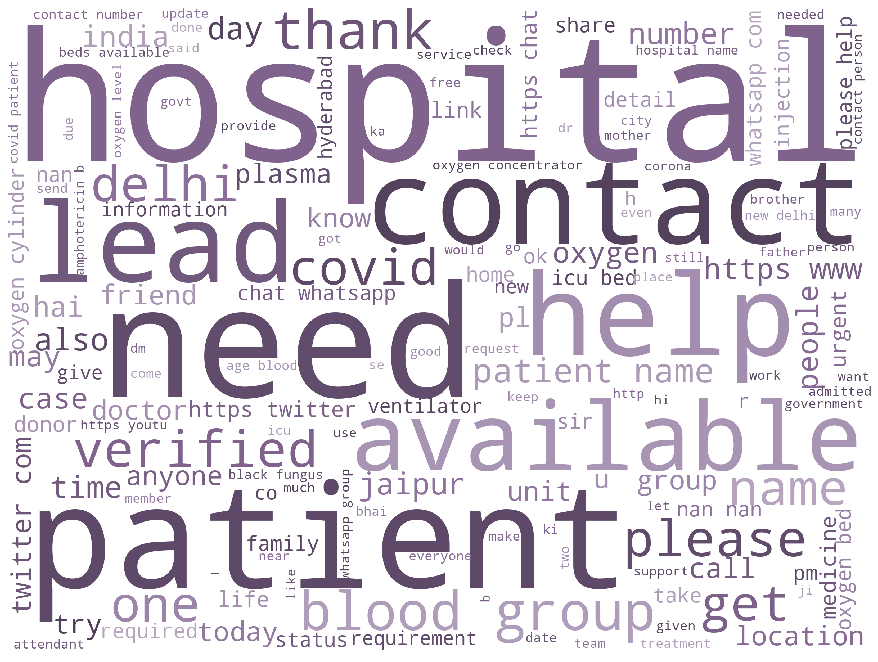

In [54]:
fig = plt.figure()
# iterate through the csv file
for val in df_covid_all_english["english_content"]:    
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 600, 
                scale=3,max_words=150,#colormap='RdYlGn',
                background_color ='white', #min_font_size = 10
                color_func=similar_color_func,
                stopwords = stop_words,
                max_font_size=256,
                random_state=42,
                ).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (12, 9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [58]:
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(comment_words)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:10])
print(list(rel_freq.items())[:10])

[('hospital', 1200), ('need', 890), ('patient', 748), ('contact', 659), ('help', 595), ('lead', 562), ('available', 560), ('blood group', 531), ('thank', 527), ('verified', 473)]
[('hospital', 1.0), ('need', 0.7416666666666667), ('patient', 0.6233333333333333), ('contact', 0.5491666666666667), ('help', 0.49583333333333335), ('lead', 0.4683333333333333), ('available', 0.4666666666666667), ('blood group', 0.4425), ('thank', 0.43916666666666665), ('verified', 0.39416666666666667)]


# Find if the factchecker.in verified numbers are contained in the text

In [60]:
verified_resource_list = pd.read_csv('factchecker_covid_list.csv')

In [113]:
df_covid.head(5)

In [65]:
WA_text = df_covid_all_english
verified_resource_list = pd.read_csv('factchecker_covid_list.csv')
phonelist = verified_resource_list['phone_1'].append(verified_resource_list['phone_2'])
phonelist.dropna(inplace=True) 
for phone in phonelist:

    check = WA_text[WA_text['english_content'].str.contains(phone, na=False)]
    if not check.empty:
        print(phone)
        print(check['english_content'])
    
#WA_text_verified = WA_text[WA_text['Content'].str.contains('|'.join(phonelist))]

In [132]:
df_phone_10 = WA_text[WA_text['Content'].str.contains("(^|[^\d])(\d{10})($|[^\d])",regex=True)]
df_phone_11 = WA_text[WA_text['Content'].str.contains("(^|[^\d])(\d{11})($|[^\d])",regex=True)]
df_phone_12 = WA_text[WA_text['Content'].str.contains("(^|[^\d])(\d{12})($|[^\d])",regex=True)]
df_phone_8 = WA_text[WA_text['Content'].str.contains("(^|[^\d])(\d{8})($|[^\d]) ",regex=True)]


In [133]:
df_phone_10.shape
#df_phone_11.shape
#df_phone_12.shape

(727, 14)

In [134]:
#df_phone = pd.merge(df_phone_10,df_phone_11,how="outer", on='ID')
df_phone = pd.concat([df_phone_8,df_phone_10,df_phone_11,df_phone_12])
df_phone.drop_duplicates(keep='first',inplace=True)

In [135]:
df_phone.shape

(928, 14)

In [128]:
leads=df_phone[df_phone['Content'].str.contains('verif')]

In [136]:
df_phone.to_csv('phones_messages.csv')
df_phone = pd.merge(df_phone,df_phone_12,how="outer", on='ID')

In [141]:
df_available = pd.read_csv('phones_messages_available.csv')

In [143]:
available = df_available[df_available['available']==1]

In [157]:
temp = available['Content'].str.extract("(^|[^\d])(\d{10})($|[^\d])")

In [162]:
temp = temp.append(available['Content'].str.extract("(^|[^\d])(\d{12})($|[^\d])"))
temp = temp.append(available['Content'].str.extract("(^|[^\d])(\d{8})($|[^\d]) "))

In [165]:
temp.to_csv('phone_numbers_list_available.csv')

In [166]:
temp.dropna(inplace=True)

In [64]:
temp.drop_duplicates(subset=[1], keep='first', inplace=False)

## Find if the Cov.Social scam numbers are contained in the text¶

In [70]:
with open('scam_posts.json') as f:
  scam_data_dict = json.load(f)

In [98]:
scam_data_dict[1]

{'region': {'location': {'coordinates': []}, 'name': ''},
 'is_reported_by_credible_source': False,
 '_id': '6090028c54034700264e0793',
 'phone': '75013 58586',
 'upi': '',
 'account_number': '',
 'comment': '',
 'entity_name': '',
 'date_added': '2021-05-03T14:02:52.130Z',
 '__v': 0}

In [72]:
scam_data = pd.DataFrame.from_dict(scam_data_dict)

In [77]:
scam_data.shape

(811, 11)

In [76]:
phonelist = scam_data["phone"]

In [78]:
phonelist = phonelist.str.strip()  ## remove white spaces

In [80]:
phonelist.drop_duplicates(keep='first',inplace=True) ## remove duplicates

In [81]:
phonelist.shape

(647,)

In [93]:
phonelist_wc = phonelist.str.replace('\+', '')  ## get rid of +sign (such as +91) for smooth regex

In [94]:
phonelist_wc = phonelist_wc[phonelist_wc.str.len()>7] ## get rid of random numbers submitted such as 12345, 9876, 789

In [95]:
phonelist_wc.shape

(637,)

In [97]:
phonelist_wc.dropna(inplace=True) 
i = 1
for phone in phonelist_wc:
    check = WA_text[WA_text['english_content'].str.contains(phone, na=False)]
    if not check.empty:
        print(i)
        print(phone)
        print(check['english_content'])
        i+= 1
        

## Find External Links in Text Messages

In [100]:
searchfor = ['.com/','.me/','.in/','https','.be/','.org/','.gl/','.co.in/','.am/','t.co/']
temp = WA_text[WA_text['content'].str.contains('|'.join(searchfor),na=False, flags=re.IGNORECASE)]#.sum()

In [101]:
temp.shape

(1406, 13)

In [112]:
temp[temp['content'].str.contains('twitter.com/|t.co/',na=False, flags=re.IGNORECASE)].shape

(237, 13)